In [1]:
## import some packages
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as mp

from tensorflow.keras.layers import Lambda, Input, Dense
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, Callback


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


import tensorflow as tf
from cbrain.imports import *

from cbrain.utils import *
import pandas as ps
from cbrain.data_generator import DataGenerator

# reparameterization trick of VAE 
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    based on VAE presented on keras webpage for keras version 1 /
    recent keras VAE version can be seen on
    https://keras.io/examples/generative/vae/
    """

    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon=K.random_normal(shape=(batch,dim)) # epsilion= random_normal distributed tensor
    sample_prob=z_mean+K.exp(0.5*z_log_var)*epsilon #exp= elementwise exponential
    return sample_prob

# kl annealing to improve reproduction skills of VAE 
klstart = 2
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 5

class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart :
            new_weight = min(K.get_value(self.weight) + (1./kl_annealtime), 1.)
            K.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(K.get_value(self.weight)))


# the starting value of weight is 0
# define it as a keras backend variable
weight = K.variable(0.)

    
original_dim_input=64  # input node size (CAM variables)

original_dim_output=int(65+64) # output node size (SP + CAM variables)


# network parameters
input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 463 # nodes in first hidden layers of encoder and last hidden layers of decoder 
batch_size = 714
latent_dim = 5 # latent space dimensions
epochs = 40    
    
## Encoder 
inputs =Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation='relu')(inputs)
x_1 =Dense(intermediate_dim, activation='relu')(x_0)
x_2 =Dense(int(np.round(intermediate_dim/2)), activation='relu')(x_1)
x_3 =Dense(int(np.round(intermediate_dim/4)), activation='relu')(x_2)
x_4 =Dense(int(np.round(intermediate_dim/8)), activation='relu')(x_3)
x_5 =Dense(int(np.round(intermediate_dim/16)), activation='relu')(x_4)



z_mean = Dense(latent_dim, name='z_mean')(x_5)
z_log_var = Dense(latent_dim, name='z_log_var')(x_5)



# reparametrization trick
z = Lambda(sampling, output_shape=(latent_dim), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


## Decoder
decoder_inputs =Input(shape=(latent_dim,), name='decoder_input')
x_1 =Dense(int(np.round(intermediate_dim/16)), activation='relu')(decoder_inputs)
x_2 =Dense(int(np.round(intermediate_dim/8)), activation='relu')(x_1)
x_3 =Dense(int(np.round(intermediate_dim/4)), activation='relu')(x_2)
x_4 =Dense(int(np.round(intermediate_dim/2)), activation='relu')(x_3)
x_5 =Dense(intermediate_dim, activation='relu')(x_4)
x_6 =Dense(intermediate_dim, activation='relu')(x_5)

outputs = Dense(original_dim_output, activation='elu')(x_6)

decoder = Model(decoder_inputs, outputs, name='decoder')
decoder.summary()

emul_outputs=decoder(encoder(inputs)[2])

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
VAE_loss = K.mean(kl_loss*weight)


VAE_clim_clim_conv=Model(inputs,emul_outputs)
VAE_clim_clim_conv.add_loss(VAE_loss)
VAE_clim_clim_conv.add_metric(kl_loss, name='kl_loss', aggregation='mean')


#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/Scaling_cond_VAE.csv')


PHQ_std_surf=scale_array.PHQ_std.values[-1]

TPHYSTND_std_23=scale_array.TPHYSTND_std.values[-1]# for dT/dt we are using the std on level 23 ~ 845 hPa

PRECT_std=scale_array.PRECT_std.values
FSNS_std=scale_array.FSNS_std.values
FSNT_std=scale_array.FSNT_std.values
FLNS_std=scale_array.FLNS_std.values
FLNT_std=scale_array.FLNT_std.values

# and the CAM variables 
scale_array_2D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range_profiles.csv')
scale_array_1D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range.csv')

TBP_std_surf=scale_array_2D.TBP_std.values[-1]

QBP_std_surf=scale_array_2D.QBP_std.values[-1]

Q_lat_std_surf=scale_array_1D.Q_lat_std.values

Q_sens_std_surf=scale_array_1D.Q_sens_std.values


Q_solar_std_surf=scale_array_1D.Q_sol_std.values

PS_std_surf=scale_array_1D.PS_std.values


# defining the scaling dict for the VAE training 

scale_dict_II = {
    'PHQ': 1/PHQ_std_surf, 
    'QBP':1/QBP_std_surf,
    'TPHYSTND': 1/TPHYSTND_std_23, 
    'TBP':1/TBP_std_surf,
    'FSNT': 1/FSNT_std, 
    'FSNS': 1/FSNS_std, 
    'FLNT': 1/FLNT_std, 
    'FLNS': 1/FLNS_std, 
    'PRECT': 1/PRECT_std, 
    'LHFLX': 1/Q_lat_std_surf, 
    'SHFLX': 1/Q_sens_std_surf, 
    'SOLIN': 1/Q_solar_std_surf,
    'PS':1/PS_std_surf
}

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT','QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']

## CAM variables
#QBP = specific humidity
#TBP = temperature 
#PS = surface pressure 
#SOLIN = solar insolation
#SHFLX = surface sensible heat flux 
#LHFLX = surface latent heat flux

##  SP variables=
#PHQ = specific humidity tendency 
#TPHYSTND = temperature tendency 
#FSNT = shortwave heat flux model top
#FSNS = shortwave heat flux model surface 
#FLNT = longwave heat flux model top (OLR)
#FLNS = longwave heat flux model surface 
#PRECT = precipitation rate 

# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];




from cbrain.data_generator import DataGenerator

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 463)          30095       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 463)          214832      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 232)          107648      dense_1[0][0]                    
____________________________________________________________________________________________

In [2]:
val_gen_II = DataGenerator(
    data_fn = '../preprocessed_data/1918_train_3_month_OND.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../preprocessed_data/000_norm_1_month.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=8192,
    shuffle=True
)


lat=np.arange(-90,90,180/64)
lon=np.arange(-180,180,360/128)
time=4415

In [3]:
VAE_clim_clim_conv.load_weights('./saved_models/VAE_clim_clim_conv/VAE_clim_clim_conv_BN5_40_opt_anneal.h5')

load the latent space time series of VAE (VAE$_{clim \rightarrow clim + conv}$) of the test data set 

In [4]:
encoder_resp_=np.load('VAE_clim_clim_conv_encoder_pred_3_month_global.npy')

compute the reference state based on median values z$_{median}$

In [5]:
encoder_resp_median=np.median(encoder_resp_,0)*np.ones((1,1))

compute the percentiles of each marginal distribution, which will be used for z$_{translation}$

In [6]:
encoder_resp_perc_75=np.percentile(encoder_resp_,75,0)*np.ones((1,1))
encoder_resp_perc_90=np.percentile(encoder_resp_,90,0)*np.ones((1,1))

encoder_resp_perc_25=np.percentile(encoder_resp_,25,0)*np.ones((1,1))
encoder_resp_perc_10=np.percentile(encoder_resp_,10,0)*np.ones((1,1))


Feed the reference state to the decoder to get average conditions 

In [7]:
Overall_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_resp_median))

Now we compute the effect of z$_{translation}$ for each latent node on the generated variable list

We swap the order of the nodes to seperate the large-scale nodes from sub-grid-scale ones 

original latent node 1 $\rightarrow$ Node 3

original latent node 2 $\rightarrow$ Node 2

original latent node 3 $\rightarrow$ Node 4

original latent node 4 $\rightarrow$ Node 5

original latent node 5 $\rightarrow$ Node 1

# Node 1  Global temperature variations

 generate z$_{translation}$ for the 75$^{th}$,25$^{th}$,90$^{th}$ and 10$^{th}$ percentile along Node 1

In [8]:
encoder_1_75_median=np.zeros((1,5))
encoder_1_75_median[0,4]=encoder_resp_perc_75[0][4]
encoder_1_75_median[0,0:4]=encoder_resp_median[0][0:4]
print(encoder_1_75_median)
print(encoder_resp_median)
First_perc_75_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_1_75_median))

[[ 3.51384652 -1.47546458  1.44382924 -1.63867188  0.97157772]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [9]:
encoder_1_25_median=np.zeros((1,5))
encoder_1_25_median[0,4]=encoder_resp_perc_25[0][4]
encoder_1_25_median[0,0:4]=encoder_resp_median[0][0:4]
print(encoder_1_25_median)
print(encoder_resp_median)
First_perc_25_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_1_25_median))

[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -5.70426571]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [10]:
encoder_1_90_median=np.zeros((1,5))
encoder_1_90_median[0,4]=encoder_resp_perc_90[0][4]
encoder_1_90_median[0,0:4]=encoder_resp_median[0][0:4]
print(encoder_1_90_median)
print(encoder_resp_median)
First_perc_90_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_1_90_median))

[[ 3.51384652 -1.47546458  1.44382924 -1.63867188  3.91702096]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [11]:
encoder_1_10_median=np.zeros((1,5))
encoder_1_10_median[0,4]=encoder_resp_perc_10[0][4]
encoder_1_10_median[0,0:4]=encoder_resp_median[0][0:4]
print(encoder_1_10_median)
print(encoder_resp_median)
First_perc_10_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_1_10_median))

[[  3.51384652  -1.47546458   1.44382924  -1.63867188 -12.37090683]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [12]:
# create label dictionary based on out_vars

out_labels=['dq/dt '+str(np.round(P[0]/100)),
           'dq/dt '+str(np.round(P[1]/100)),
           'dq/dt '+str(np.round(P[2]/100)),
           'dq/dt '+str(np.round(P[3]/100)),
           'dq/dt '+str(np.round(P[4]/100)),
           'dq/dt '+str(np.round(P[5]/100)),
           'dq/dt '+str(np.round(P[6]/100)),
           'dq/dt '+str(np.round(P[7]/100)),
           'dq/dt '+str(np.round(P[8]/100)),
           'dq/dt '+str(np.round(P[9]/100)),
           'dq/dt '+str(np.round(P[10]/100)),
           'dq/dt '+str(np.round(P[11]/100)),
           'dq/dt '+str(np.round(P[12]/100)),
           'dq/dt '+str(np.round(P[13]/100)),
           'dq/dt '+str(np.round(P[14]/100)),
           'dq/dt '+str(np.round(P[15]/100)),
           'dq/dt '+str(np.round(P[16]/100)),
           'dq/dt '+str(np.round(P[17]/100)),
           'dq/dt '+str(np.round(P[18]/100)),
           'dq/dt '+str(np.round(P[19]/100)),
           'dq/dt '+str(np.round(P[20]/100)),
           'dq/dt '+str(np.round(P[21]/100)),
           'dq/dt '+str(np.round(P[22]/100)),
           'dq/dt '+str(np.round(P[23]/100)),
           'dq/dt '+str(np.round(P[24]/100)),
           'dq/dt '+str(np.round(P[25]/100)),
           'dq/dt '+str(np.round(P[26]/100)),
           'dq/dt '+str(np.round(P[27]/100)),
           'dq/dt '+str(np.round(P[28]/100)),
           'dq/dt '+str(np.round(P[29]/100)),
        'dT/dt '+str(np.round(P[0]/100)),'','','',        
        'dT/dt '+str(np.round(P[4]/100)),'','','','',
        'dT/dt '+str(np.round(P[9]/100)),'','','','',        
        'dT/dt '+str(np.round(P[14]/100)),'','','','',
        'dT/dt '+str(np.round(P[19]/100)),'','','','',
        'dT/dt '+str(np.round(P[24]/100)),'','','','',
        'dT/dt '+str(np.round(P[29]/100)),r'Q$_{sw \ top}$ '+r'$[\frac{W}{m^2}]$',r'Q$_{sw \ surf}$ '+r'$[\frac{W}{m^2}]$',
            r'Q$_{lw \ top}$ '+r'$[\frac{W}{m^2}]$',r'Q$_{lw \ surf}$ '+r'$[\frac{W}{m^2}]$','precip ' +r'$[\frac{mm}{h}]$']


in_labels=['Q '+str(np.round(P[0]/100)),
           'Q '+str(np.round(P[1]/100)),
           'Q '+str(np.round(P[2]/100)),
           'Q '+str(np.round(P[3]/100)),
           'Q '+str(np.round(P[4]/100)),
           'Q '+str(np.round(P[5]/100)),
           'Q '+str(np.round(P[6]/100)),
           'Q '+str(np.round(P[7]/100)),
           'Q '+str(np.round(P[8]/100)),
           'Q '+str(np.round(P[9]/100)),
           'Q '+str(np.round(P[10]/100)),
           'Q '+str(np.round(P[11]/100)),
           'Q '+str(np.round(P[12]/100)),
           'Q '+str(np.round(P[13]/100)),
           'Q '+str(np.round(P[14]/100)),
           'Q '+str(np.round(P[15]/100)),
           'Q '+str(np.round(P[16]/100)),
           'Q '+str(np.round(P[17]/100)),
           'Q '+str(np.round(P[18]/100)),
           'Q '+str(np.round(P[19]/100)),
           'Q '+str(np.round(P[20]/100)),
           'Q '+str(np.round(P[21]/100)),
           'Q '+str(np.round(P[22]/100)),
           'Q '+str(np.round(P[23]/100)),
           'Q '+str(np.round(P[24]/100)),
           'Q '+str(np.round(P[25]/100)),
           'Q '+str(np.round(P[26]/100)),
           'Q '+str(np.round(P[27]/100)),
           'Q '+str(np.round(P[28]/100)),
           'Q '+str(np.round(P[29]/100)),
        'T '+str(np.round(P[0]/100)),'','','',        
        'T '+str(np.round(P[4]/100)),'','','','',
        'T '+str(np.round(P[9]/100)),'','','','',        
        'T '+str(np.round(P[14]/100)),'','','','',
        'T '+str(np.round(P[19]/100)),'','','','',
        'T '+str(np.round(P[24]/100)),'','','','',
        'T '+str(np.round(P[29]/100))+r' $[K]$',r'P$_{surf}$'+' [hPa]',r'Q$_{sol}$ '+r'$[\frac{W}{m^2}]$'
           ,r'Q$_{sens}$ '+r'$[\frac{W}{m^2}$]',r'Q$_{lat}$ '+r'$[\frac{W}{m^2}$]']




        
all_labels=out_labels+in_labels


In [13]:
# and a scaling dictionary to convert to units used in paper 
scaling_arr=np.zeros(129)
scaling_arr[0:30]=3600 *1000
scaling_arr[30:60]=3600 
scaling_arr[65:95]=1000
scaling_arr[95:125]=1
scaling_arr[60:64]=1
scaling_arr[64]=1000*3600
scaling_arr[125]=1E-2
scaling_arr[126:129]=1


In [14]:
# selected percentiles 

eval_perc=np.array([10,25,50,75,90])


In [15]:
def quad_plot_profiles_updat_rev(encoder_dim,encoder_median_dim,encoder_perc_1,encoder_perc_2,
                       encoder_perc_3,encoder_perc_4,hist_max,VAE_median,VAE_perc_1,
                       VAE_perc_2,VAE_perc_3,VAE_perc_4,
                       press,special_2_D_var_1,special_2_D_var_2,
                       labels,scal_arr,label_0,label_1,label_2,label_3,label_4,percentiles):
    
    """
    author: Gunnar Behrens
    Plot generated profiles and table for z_translation and z_median 
    """
    import pandas as pd 
    Press=press/100
    import matplotlib as mpl
    import matplotlib.pylab as plb    
    
    
    
    c_map=[[0,0,1,0.5],[0,0,0.6,1],[0,0,0,1],[0,0.4,0.5,1],[0.6,0.4,0,1]]
    #print(c_map)
    plt.figure(1,(17,15))
    ax_1=plt.subplot(2,3,1)
    
    ax_1.hist(encoder_dim,29,density=True,stacked=True,color=[0,0.8,0.7,1])
    ax_1.vlines(encoder_median_dim,0,hist_max,linewidth=3,color=c_map[2],linestyles='dashed',label="global median")
    ax_1.vlines(encoder_perc_1,0,hist_max,linewidth=3,color=c_map[0],linestyles='dashed',label=label_1)
    ax_1.vlines(encoder_perc_2,0,hist_max,linewidth=3,color=c_map[1],linestyles='dashed',label=label_2)
    ax_1.vlines(encoder_perc_3,0,hist_max,linewidth=3,color=c_map[3],linestyles='dashed',label=label_3)
    ax_1.vlines(encoder_perc_4,0,hist_max,linewidth=3,color=c_map[4],linestyles='dashed',label=label_4)


    steps_size=0.02
    plt.ylim([0,hist_max])
    plt.yticks(np.arange(0,hist_max-steps_size/2+1E-6,steps_size))
    plt.xlim([-20,20])
    plt.grid([True])
    plt.xticks(Fontsize=16)
    plt.yticks(Fontsize=16)
    plt.ylabel('Probability', Fontsize=20)
    plt.title('a)  Marginal Distribution',Fontsize=24)
    
    
    
    ax_2=plt.subplot(2,3,2)
    ax_2.plot(VAE_perc_1[0:30]*scal_arr[0],Press[0:30],color=c_map[0],label=label_0)
    ax_2.plot(VAE_perc_2[0:30]*scal_arr[0],Press[0:30],color=c_map[1],label=label_1)
    ax_2.plot(VAE_median[0:30]*scal_arr[0],Press[0:30],color=c_map[2],label=label_2)
    ax_2.plot(VAE_perc_3[0:30]*scal_arr[0],Press[0:30],color=c_map[3],label=label_3)
    ax_2.plot(VAE_perc_4[0:30]*scal_arr[0],Press[0:30],color=c_map[4],label=label_4)
   

    plt.title('b)  dq/dt ' +r'$[\frac{g}{kg \times h}]$', Fontsize=24)
    plt.ylabel('Pressure [hPa]', Fontsize=20)
    ax_2.set_yticklabels([])
    plt.xticks(np.arange(-4E-1,5E-1,1E-1),Fontsize=16)
    plt.xlim([-0.3,0.4])
    plt.ylim([0,1000])
    plt.grid(True)
    inv=plt.gca()
    inv.invert_yaxis()
    
    ax_3=plt.subplot(2,3,3)
    plt.plot(VAE_perc_1[30:60]*scal_arr[30],Press[0:30],color=c_map[0],label=label_0)
    plt.plot(VAE_perc_2[30:60]*scal_arr[30],Press[0:30],color=c_map[1],label=label_1)
    plt.plot(VAE_median[30:60]*scal_arr[30],Press[0:30],color=c_map[2],label=label_2)
    plt.plot(VAE_perc_3[30:60]*scal_arr[30],Press[0:30],color=c_map[3],label=label_3)
    plt.plot(VAE_perc_4[30:60]*scal_arr[30],Press[0:30],color=c_map[4],label=label_4)
    
    plt.xlim([-0.3,0.8])
    plt.ylim([0,1000])
    plt.grid(True)
    plt.yticks(Fontsize=16)
    plt.xticks(Fontsize=16)
    plt.title('c)  dT/dt '+r'$[\frac{K}{h}]$', Fontsize=24)
    inv=plt.gca()
    inv.invert_yaxis()

    
    ax_4=plt.subplot(2,3,4)
    plt.plot(VAE_perc_1[65:95]*scal_arr[65],Press[0:30],color=c_map[0],label=label_0)
    plt.plot(VAE_perc_2[65:95]*scal_arr[65],Press[0:30],color=c_map[1],label=label_1)
    plt.plot(VAE_median[65:95]*scal_arr[65],Press[0:30],color=c_map[2],label=label_2)
    plt.plot(VAE_perc_3[65:95]*scal_arr[65],Press[0:30],color=c_map[3],label=label_3)
    plt.plot(VAE_perc_4[65:95]*scal_arr[65],Press[0:30],color=c_map[4],label=label_4)
    plt.legend(prop={'size': 16})

    plt.xticks(np.arange(0,20,4),Fontsize=16)
    plt.ylabel('Pressure [hPa]', Fontsize=20)
    ax_4.set_yticklabels([])
    plt.xlim([0,17])
    plt.ylim([0,1000])
    
    plt.grid(True)
    plt.title('d)  q '+r'$[\frac{g}{kg}]$', Fontsize=24)
    inv=plt.gca()
    inv.invert_yaxis()
    
    ax_5=plt.subplot(2,3,5)
    plt.plot(VAE_perc_1[95:125]*scal_arr[95],Press[0:30],color=c_map[0],label=label_0)
    plt.plot(VAE_perc_2[95:125]*scal_arr[95],Press[0:30],color=c_map[1],label=label_1)
    plt.plot(VAE_median[95:125]*scal_arr[95],Press[0:30],color=c_map[2],label=label_2)
    plt.plot(VAE_perc_3[95:125]*scal_arr[95],Press[0:30],color=c_map[3],label=label_3)
    plt.plot(VAE_perc_4[95:125]*scal_arr[95],Press[0:30],color=c_map[4],label=label_4)
    #ax_5.text(0.87,0.93,s='e)',fontsize=32,transform=ax_5.transAxes)

    plt.xlim([190,300])
    plt.ylim([0,1000])
    plt.xticks(Fontsize=16)
    plt.yticks(Fontsize=16)
    plt.grid(True)
    plt.title('e)  T '+ r'$[K]$', Fontsize=24)
    inv=plt.gca()
    inv.invert_yaxis()
    
    
    ### special 2D var-percentile plot
    
    spec_var_1=np.array([VAE_perc_1[special_2_D_var_1],VAE_perc_2[special_2_D_var_1],
                         VAE_median[special_2_D_var_1],VAE_perc_3[special_2_D_var_1],
                         VAE_perc_4[special_2_D_var_1]])
                        
    spec_var_2=np.array([VAE_perc_1[special_2_D_var_2],VAE_perc_2[special_2_D_var_2],
                         VAE_median[special_2_D_var_2],VAE_perc_3[special_2_D_var_2],
                         VAE_perc_4[special_2_D_var_2]])
    
    
                        
    ax1=plt.subplot(2,3,6)
    
     

    ax1.set_xlabel('Percentiles',Fontsize=18)
    
    ax1.plot(percentiles,spec_var_1*scal_arr[special_2_D_var_1],color='black')
    for i in np.arange(percentiles.size):
        ax1.plot(percentiles[i],(spec_var_1*scal_arr[special_2_D_var_1])[i],color='black',marker='o',markeredgewidth=3,markeredgecolor=c_map[i],markersize=10)
    ax1.grid(True)
    ax1.set_ylabel('f)  '+labels[special_2_D_var_1], color='black',Fontsize=24,rotation='horizontal')
    ax1.tick_params(axis='y', labelcolor='black',labelsize=16)
    ax1.tick_params(axis='x', labelcolor='black',labelsize=16)             
    ax1.yaxis.set_label_coords(0.20,1.02)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel(labels[special_2_D_var_2], color=c_map[3],Fontsize=24,rotation='horizontal')  # we already handled the x-label with ax1
    ax2.plot(percentiles,spec_var_2*scal_arr[special_2_D_var_2],color=c_map[3])
    for i in np.arange(percentiles.size):
        ax2.plot(percentiles[i],(spec_var_2*scal_arr[special_2_D_var_2])[i],color=c_map[3],marker='o',markeredgewidth=3,markeredgecolor=c_map[i],markersize=10)

        
    ax2.tick_params(axis='y', labelcolor=c_map[3],labelsize=16)
    ax2.grid(True,color=c_map[3])
    plt.xticks(Fontsize=20)
    ax2.yaxis.set_label_coords(0.90,1.12)

    
                        
        
                        
                        

   
    scalar=[60,61,62,63,64,125,126,127,128,124]
    for k in scalar:
        print(k)
    dg=pd.DataFrame([[labels[k],VAE_perc_1[k]*scal_arr[k],VAE_perc_2[k]*scal_arr[k],
                      VAE_median[k]*scal_arr[k],VAE_perc_3[k]*scal_arr[k],VAE_perc_4[k]*scal_arr[k]] for k in scalar ],
                    columns=['Variable',label_0,label_1,label_2,label_3,label_4])
    

    
    
    
    return dg

get response of decoder to z$_{translation}$ along 1st latent dimension

<ipython-input-15-c8d35ab6e012>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Probability', Fontsize=20)
<ipython-input-15-c8d35ab6e012>:39: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('a)  Marginal Distribution',Fontsize=24)
<ipython-input-15-c8d35ab6e012>:51: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pl

60
61
62
63
64
125
126
127
128
124


<ipython-input-15-c8d35ab6e012>:131: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_xlabel('Percentiles',Fontsize=18)
<ipython-input-15-c8d35ab6e012>:137: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_ylabel('f)  '+labels[special_2_D_var_1], color='black',Fontsize=24,rotation='horizontal')
<ipython-input-15-c8d35ab6e012>:143: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel(labels[special_2_D_var_2], color=c_map[3],Fontsize=24,rotation='horizontal')  # we already handled the x-label with ax1
<ipython-input-15-c8d35ab6e012>:151: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=20)


,Variable,10$^{th}$ perc,25$^{th}$ perc,50$^{th}$ perc,75$^{th}$ perc,90$^{th}$ perc
0,Q$_{sw \ top}$ $[\frac{W}{m^2}]$,[4.385172],[115.25428],[450.70715],[36.017307],[6.252763]
1,Q$_{sw \ surf}$ $[\frac{W}{m^2}]$,[-1.1653343],[49.07162],[284.20877],[24.035215],[1.3438382]
2,Q$_{lw \ top}$ $[\frac{W}{m^2}]$,[180.82594],[220.85008],[241.11543],[259.76227],[275.31348]
3,Q$_{lw \ surf}$ $[\frac{W}{m^2}]$,[54.927242],[12.055199],[27.731419],[59.812008],[43.593822]
4,precip $[\frac{mm}{h}]$,[0.10793317],[0.0143879065],[0.02631393],[0.117693745],[0.068120636]
5,P$_{surf}$ [hPa],[932.9657],[982.1021],[994.8684],[994.7035],[989.43726]
6,Q$_{sol}$ $[\frac{W}{m^2}]$,[14.821716],[262.55136],[748.1307],[45.3256],[8.041117]
7,Q$_{sens}$ $[\frac{W}{m^2}$],[24.885063],[9.412138],[2.7806473],[9.49981],[11.9544935]
8,Q$_{lat}$ $[\frac{W}{m^2}$],[52.350517],[19.396908],[38.913197],[85.171104],[163.07196]
9,T 985.0 $[K]$,[272.9677],[276.08994],[286.91608],[294.12482],[298.35153]


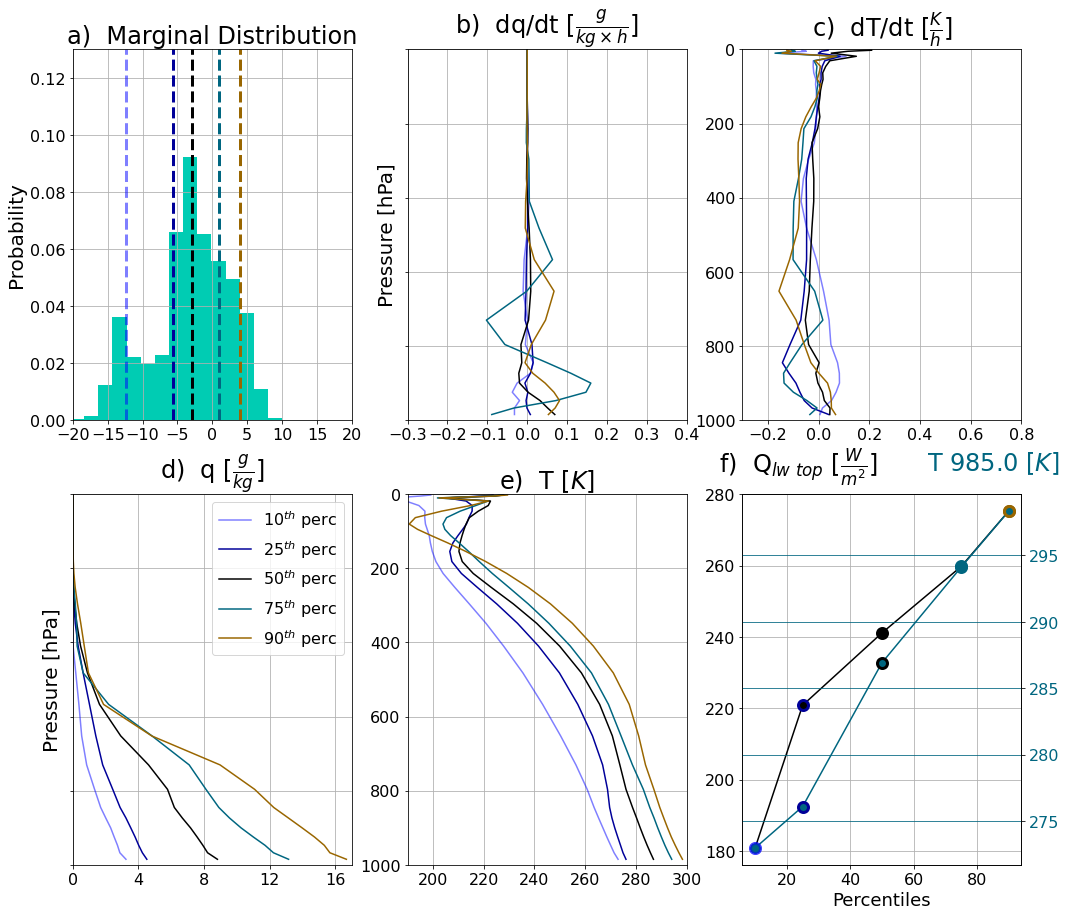

In [16]:
quad_plot_profiles_updat_rev(encoder_resp_[:,4],np.median(encoder_resp_[:,4]),
                   encoder_resp_perc_10[:,4],encoder_resp_perc_25[:,4],encoder_resp_perc_75[:,4],
                   encoder_resp_perc_90[:,4],0.13,Overall_median.T,First_perc_10_median.T,First_perc_25_median.T,
                         First_perc_75_median.T,First_perc_90_median.T,
                   P,62,124,all_labels,scaling_arr,'10$^{th}$ perc','25$^{th}$ perc','50$^{th}$ perc',
                   '75$^{th}$ perc','90$^{th}$ perc',eval_perc)

# Node 2 Large-scale variability along the mid-latitude storm tracks

get response of decoder to z$_{translation}$ along 2nd latent dimension

In [17]:
encoder_2_75_median=np.zeros((1,5))
encoder_2_75_median[0,1]=encoder_resp_perc_75[0][1]
encoder_2_75_median[0,2:5]=encoder_resp_median[0][2:5]
encoder_2_75_median[0,0]=encoder_resp_median[0][0]

print(encoder_2_75_median)
print(encoder_resp_median)
Second_perc_75_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_2_75_median))

[[ 3.51384652  0.8504931   1.44382924 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [18]:
encoder_2_25_median=np.zeros((1,5))
encoder_2_25_median[0,1]=encoder_resp_perc_25[0][1]
encoder_2_25_median[0,2:5]=encoder_resp_median[0][2:5]
encoder_2_25_median[0,0]=encoder_resp_median[0][0]

print(encoder_2_25_median)
print(encoder_resp_median)
Second_perc_25_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_2_25_median))

[[  3.51384652 -10.05493951   1.44382924  -1.63867188  -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [19]:
encoder_2_90_median=np.zeros((1,5))
encoder_2_90_median[0,1]=encoder_resp_perc_90[0][1]
encoder_2_90_median[0,2:5]=encoder_resp_median[0][2:5]
encoder_2_90_median[0,0]=encoder_resp_median[0][0]

print(encoder_2_90_median)
print(encoder_resp_median)
Second_perc_90_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_2_90_median))

[[ 3.51384652  4.0902277   1.44382924 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [20]:
encoder_2_10_median=np.zeros((1,5))
encoder_2_10_median[0,1]=encoder_resp_perc_10[0][1]
encoder_2_10_median[0,2:5]=encoder_resp_median[0][2:5]
encoder_2_10_median[0,0]=encoder_resp_median[0][0]

print(encoder_2_10_median)
print(encoder_resp_median)
Second_perc_10_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_2_10_median))

[[  3.51384652 -13.75372324   1.44382924  -1.63867188  -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


60
61
62
63
64
125
126
127
128
124


<ipython-input-15-c8d35ab6e012>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Probability', Fontsize=20)
<ipython-input-15-c8d35ab6e012>:39: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('a)  Marginal Distribution',Fontsize=24)
<ipython-input-15-c8d35ab6e012>:51: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pl

,Variable,10$^{th}$ perc,25$^{th}$ perc,50$^{th}$ perc,75$^{th}$ perc,90$^{th}$ perc
0,Q$_{sw \ top}$ $[\frac{W}{m^2}]$,[987.34753],[1092.2788],[450.70715],[56.904053],[158.27257]
1,Q$_{sw \ surf}$ $[\frac{W}{m^2}]$,[772.5866],[845.191],[284.20877],[29.812014],[49.44739]
2,Q$_{lw \ top}$ $[\frac{W}{m^2}]$,[252.19888],[248.62804],[241.11543],[205.35458],[173.03337]
3,Q$_{lw \ surf}$ $[\frac{W}{m^2}]$,[85.1793],[72.963264],[27.731419],[44.153793],[12.7084875]
4,precip $[\frac{mm}{h}]$,[-0.011406662],[0.0010883465],[0.02631393],[0.12336302],[0.14857471]
5,P$_{surf}$ [hPa],[983.21594],[988.6009],[994.8684],[993.21045],[992.2962]
6,Q$_{sol}$ $[\frac{W}{m^2}]$,[1213.9882],[1346.5116],[748.1307],[124.62692],[442.70047]
7,Q$_{sens}$ $[\frac{W}{m^2}$],[18.53178],[8.622262],[2.7806473],[6.3773484],[22.743393]
8,Q$_{lat}$ $[\frac{W}{m^2}$],[82.940575],[54.98646],[38.913197],[85.66417],[100.89523]
9,T 985.0 $[K]$,[280.8604],[283.58536],[286.91608],[289.799],[291.49982]


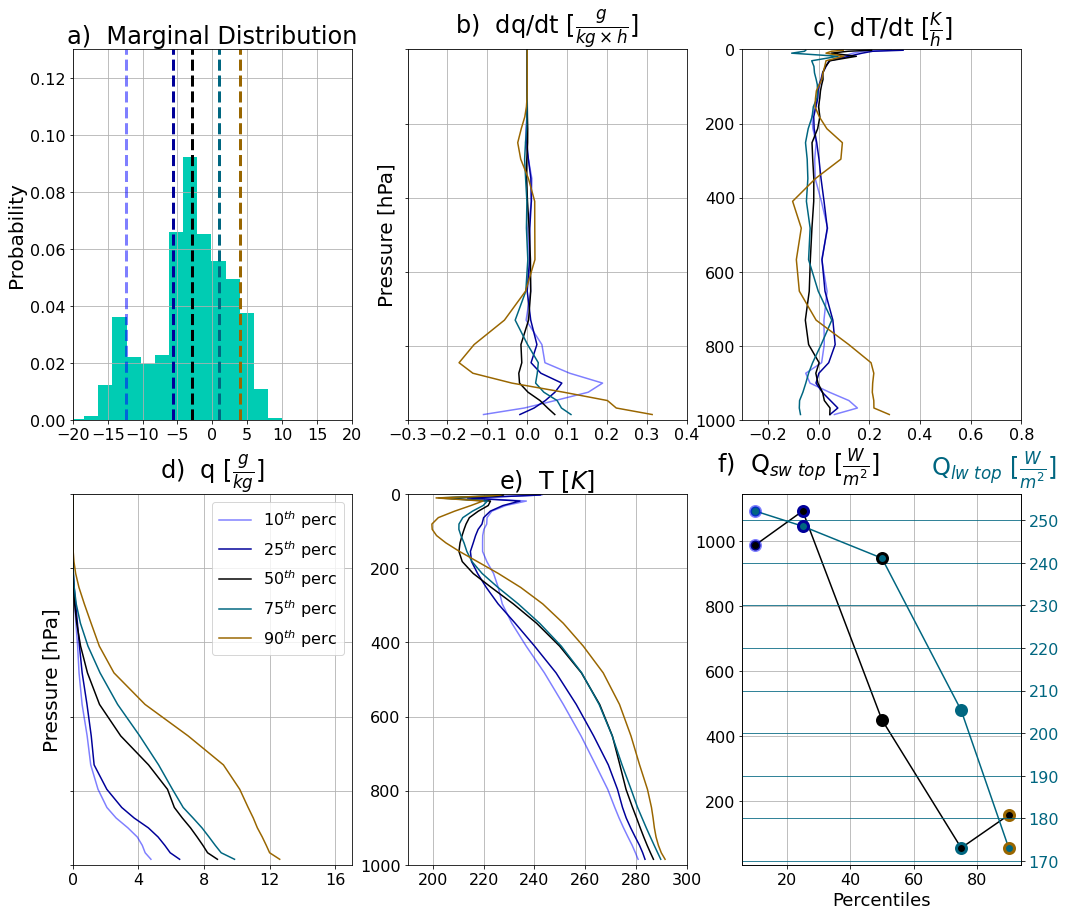

In [21]:
quad_plot_profiles_updat_rev(encoder_resp_[:,4],np.median(encoder_resp_[:,4]),
                   encoder_resp_perc_10[:,4],encoder_resp_perc_25[:,4],encoder_resp_perc_75[:,4],
                   encoder_resp_perc_90[:,4],0.13,Overall_median.T,Second_perc_10_median.T,Second_perc_25_median.T,
                         Second_perc_75_median.T,Second_perc_90_median.T,
                   P,60,62,all_labels,scaling_arr,'10$^{th}$ perc','25$^{th}$ perc','50$^{th}$ perc',
                   '75$^{th}$ perc','90$^{th}$ perc',eval_perc)

# Node 3 Shallow Convection

get response of decoder to z$_{translation}$ along 3rd latent dimension

In [22]:
encoder_3_75_median=np.zeros((1,5))
encoder_3_75_median[0,0]=encoder_resp_perc_75[0][0]
encoder_3_75_median[0,1:5]=encoder_resp_median[0][1:5]
print(encoder_3_75_median)
print(encoder_resp_median)
Third_perc_75_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_3_75_median))

[[ 7.98035336 -1.47546458  1.44382924 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [23]:
encoder_3_25_median=np.zeros((1,5))
encoder_3_25_median[0,0]=encoder_resp_perc_25[0][0]
encoder_3_25_median[0,1:5]=encoder_resp_median[0][1:5]
print(encoder_3_25_median)
print(encoder_resp_median)
Third_perc_25_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_3_25_median))

[[ 1.50452766 -1.47546458  1.44382924 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [24]:
encoder_3_90_median=np.zeros((1,5))
encoder_3_90_median[0,0]=encoder_resp_perc_90[0][0]
encoder_3_90_median[0,1:5]=encoder_resp_median[0][1:5]
print(encoder_3_90_median)
print(encoder_resp_median)
Third_perc_90_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_3_90_median))

[[ 9.83392057 -1.47546458  1.44382924 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [25]:
encoder_3_10_median=np.zeros((1,5))
encoder_3_10_median[0,0]=encoder_resp_perc_10[0][0]
encoder_3_10_median[0,1:5]=encoder_resp_median[0][1:5]
print(encoder_3_10_median)
print(encoder_resp_median)
Third_perc_10_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_3_10_median))

[[-0.3918813  -1.47546458  1.44382924 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


<ipython-input-15-c8d35ab6e012>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Probability', Fontsize=20)
<ipython-input-15-c8d35ab6e012>:39: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('a)  Marginal Distribution',Fontsize=24)
<ipython-input-15-c8d35ab6e012>:51: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pl

60
61
62
63
64
125
126
127
128
124


<ipython-input-15-c8d35ab6e012>:107: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:108: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:110: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('e)  T '+ r'$[K]$', Fontsize=24)
<ipython-input-15-c8d35ab6e012>:131: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_xlabel('Percentiles',Fontsize=18)
<ipython-input-15-c8d35ab6e012>:137: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax

,Variable,10$^{th}$ perc,25$^{th}$ perc,50$^{th}$ perc,75$^{th}$ perc,90$^{th}$ perc
0,Q$_{sw \ top}$ $[\frac{W}{m^2}]$,[4.9730744],[133.6459],[450.70715],[1199.8126],[1111.6821]
1,Q$_{sw \ surf}$ $[\frac{W}{m^2}]$,[1.9149284],[48.732635],[284.20877],[925.2547],[837.65063]
2,Q$_{lw \ top}$ $[\frac{W}{m^2}]$,[178.4277],[220.07658],[241.11543],[251.03268],[255.44499]
3,Q$_{lw \ surf}$ $[\frac{W}{m^2}]$,[2.544288],[7.9132605],[27.731419],[73.27548],[72.49094]
4,precip $[\frac{mm}{h}]$,[0.0842708],[0.052024495],[0.02631393],[0.041620202],[0.047321998]
5,P$_{surf}$ [hPa],[984.8649],[998.77747],[994.8684],[990.63605],[990.91187]
6,Q$_{sol}$ $[\frac{W}{m^2}]$,[14.534274],[329.26614],[748.1307],[1488.2721],[1468.4307]
7,Q$_{sens}$ $[\frac{W}{m^2}$],[-14.853678],[-10.798028],[2.7806473],[30.395252],[50.638386]
8,Q$_{lat}$ $[\frac{W}{m^2}$],[-32.855007],[-13.215715],[38.913197],[206.76666],[241.50195]
9,T 985.0 $[K]$,[286.34927],[285.76117],[286.91608],[289.86798],[288.00415]


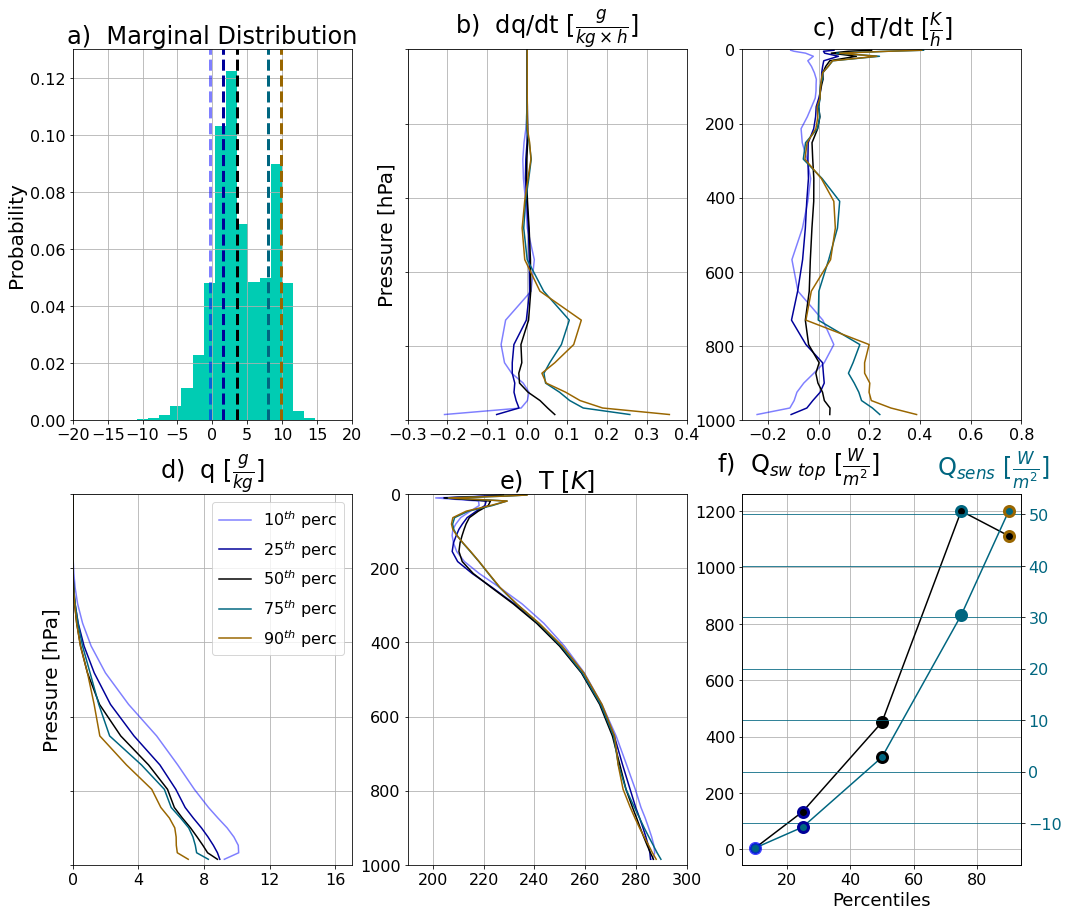

In [28]:
quad_plot_profiles_updat_rev(encoder_resp_[:,0],np.median(encoder_resp_[:,0]),
                   encoder_resp_perc_10[:,0],encoder_resp_perc_25[:,0],encoder_resp_perc_75[:,0],
                   encoder_resp_perc_90[:,0],0.13,Overall_median.T,Third_perc_10_median.T,Third_perc_25_median.T,
                         Third_perc_75_median.T,Third_perc_90_median.T,
                   P,60,127,all_labels,scaling_arr,'10$^{th}$ perc','25$^{th}$ perc','50$^{th}$ perc',
                   '75$^{th}$ perc','90$^{th}$ perc',eval_perc)

# Node 4 Mid-latitude storm tracks 

get response of decoder to z$_{translation}$ along 4th latent dimension

In [29]:
encoder_4_75_median=np.zeros((1,5))
encoder_4_75_median[0,2]=encoder_resp_perc_75[0][2]
encoder_4_75_median[0,0:2]=encoder_resp_median[0][0:2]
encoder_4_75_median[0,3:5]=encoder_resp_median[0][3:5]
print(encoder_4_75_median)
print(encoder_resp_median)
Fourth_perc_75_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_4_75_median))

[[ 3.51384652 -1.47546458  3.49385262 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [30]:
encoder_4_25_median=np.zeros((1,5))
encoder_4_25_median[0,2]=encoder_resp_perc_25[0][2]
encoder_4_25_median[0,0:2]=encoder_resp_median[0][0:2]
encoder_4_25_median[0,3:5]=encoder_resp_median[0][3:5]
print(encoder_4_25_median)
print(encoder_resp_median)
Fourth_perc_25_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_4_25_median))

[[ 3.51384652 -1.47546458 -0.65265924 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [31]:
encoder_4_90_median=np.zeros((1,5))
encoder_4_90_median[0,2]=encoder_resp_perc_90[0][2]
encoder_4_90_median[0,0:2]=encoder_resp_median[0][0:2]
encoder_4_90_median[0,3:5]=encoder_resp_median[0][3:5]
print(encoder_4_90_median)
print(encoder_resp_median)
Fourth_perc_90_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_4_90_median))

[[ 3.51384652 -1.47546458  5.0206109  -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [32]:
encoder_4_10_median=np.zeros((1,5))
encoder_4_10_median[0,2]=encoder_resp_perc_10[0][2]
encoder_4_10_median[0,0:2]=encoder_resp_median[0][0:2]
encoder_4_10_median[0,3:5]=encoder_resp_median[0][3:5]
print(encoder_4_10_median)
print(encoder_resp_median)
Fourth_perc_10_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_4_10_median))

[[ 3.51384652 -1.47546458 -2.85378067 -1.63867188 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


60
61
62
63
64
125
126
127
128
124


<ipython-input-15-c8d35ab6e012>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Probability', Fontsize=20)
<ipython-input-15-c8d35ab6e012>:39: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('a)  Marginal Distribution',Fontsize=24)
<ipython-input-15-c8d35ab6e012>:51: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pl

,Variable,10$^{th}$ perc,25$^{th}$ perc,50$^{th}$ perc,75$^{th}$ perc,90$^{th}$ perc
0,Q$_{sw \ top}$ $[\frac{W}{m^2}]$,[440.49112],[456.05438],[450.70715],[435.42697],[442.03055]
1,Q$_{sw \ surf}$ $[\frac{W}{m^2}]$,[316.8736],[317.1524],[284.20877],[265.85623],[270.13773]
2,Q$_{lw \ top}$ $[\frac{W}{m^2}]$,[174.9674],[201.62897],[241.11543],[223.72464],[214.78786]
3,Q$_{lw \ surf}$ $[\frac{W}{m^2}]$,[59.468803],[52.661995],[27.731419],[38.553986],[43.094765]
4,precip $[\frac{mm}{h}]$,[0.0010077541],[0.0020977925],[0.02631393],[0.14637907],[0.24764295]
5,P$_{surf}$ [hPa],[1000.5804],[1000.0146],[994.8684],[989.64105],[986.4763]
6,Q$_{sol}$ $[\frac{W}{m^2}]$,[624.7561],[678.2274],[748.1307],[741.0134],[746.13806]
7,Q$_{sens}$ $[\frac{W}{m^2}$],[-4.620819],[-3.854778],[2.7806473],[7.5526075],[14.765463]
8,Q$_{lat}$ $[\frac{W}{m^2}$],[29.407845],[26.851175],[38.913197],[74.85313],[97.19562]
9,T 985.0 $[K]$,[290.4052],[288.6834],[286.91608],[286.55283],[285.7443]


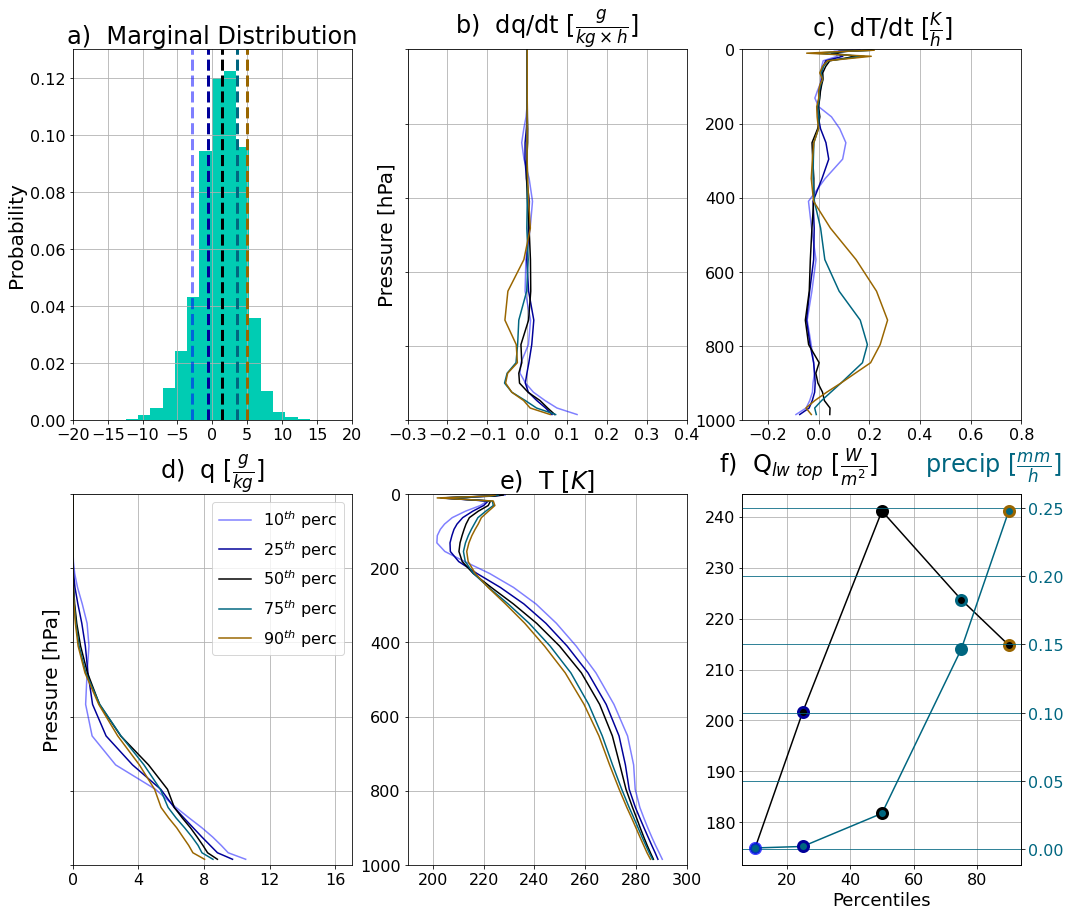

In [33]:
quad_plot_profiles_updat_rev(encoder_resp_[:,2],np.median(encoder_resp_[:,2]),
                   encoder_resp_perc_10[:,2],encoder_resp_perc_25[:,2],encoder_resp_perc_75[:,2],
                   encoder_resp_perc_90[:,2],0.13,Overall_median.T,Fourth_perc_10_median.T,Fourth_perc_25_median.T,
                         Fourth_perc_75_median.T,Fourth_perc_90_median.T,
                   P,62,64,all_labels,scaling_arr,'10$^{th}$ perc','25$^{th}$ perc','50$^{th}$ perc',
                   '75$^{th}$ perc','90$^{th}$ perc',eval_perc)

# Node 5 Deep Convection

get response of decoder to z$_{translation}$ along 5th latent dimension

In [34]:
encoder_5_75_median=np.zeros((1,5))
encoder_5_75_median[0,3]=encoder_resp_perc_75[0][3]
encoder_5_75_median[0,0:3]=encoder_resp_median[0][0:3]
encoder_5_75_median[0,4:5]=encoder_resp_median[0][4:5]
print(encoder_5_75_median)
print(encoder_resp_median)
Fifth_perc_75_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_5_75_median))

[[ 3.51384652 -1.47546458  1.44382924  0.96309471 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [35]:
encoder_5_25_median=np.zeros((1,5))
encoder_5_25_median[0,3]=encoder_resp_perc_25[0][3]
encoder_5_25_median[0,0:3]=encoder_resp_median[0][0:3]
encoder_5_25_median[0,4:5]=encoder_resp_median[0][4:5]
print(encoder_5_25_median)
print(encoder_resp_median)
Fifth_perc_25_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_5_25_median))

[[ 3.51384652 -1.47546458  1.44382924 -7.94987869 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [36]:
encoder_5_90_median=np.zeros((1,5))
encoder_5_90_median[0,3]=encoder_resp_perc_90[0][3]
encoder_5_90_median[0,0:3]=encoder_resp_median[0][0:3]
encoder_5_90_median[0,4:5]=encoder_resp_median[0][4:5]
print(encoder_5_90_median)
print(encoder_resp_median)
Fifth_perc_90_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_5_90_median))

[[ 3.51384652 -1.47546458  1.44382924  2.79797785 -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


In [37]:
encoder_5_10_median=np.zeros((1,5))
encoder_5_10_median[0,3]=encoder_resp_perc_10[0][3]
encoder_5_10_median[0,0:3]=encoder_resp_median[0][0:3]
encoder_5_10_median[0,4:5]=encoder_resp_median[0][4:5]
print(encoder_5_10_median)
print(encoder_resp_median)
Fifth_perc_10_median=val_gen_II.output_transform.inverse_transform(decoder.predict(encoder_5_10_median))

[[  3.51384652  -1.47546458   1.44382924 -10.20965681  -2.86670351]]
[[ 3.51384652 -1.47546458  1.44382924 -1.63867188 -2.86670351]]


<ipython-input-15-c8d35ab6e012>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Probability', Fontsize=20)
<ipython-input-15-c8d35ab6e012>:39: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('a)  Marginal Distribution',Fontsize=24)
<ipython-input-15-c8d35ab6e012>:51: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pl

60
61
62
63
64
125
126
127
128
124


<ipython-input-15-c8d35ab6e012>:93: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('d)  q '+r'$[\frac{g}{kg}]$', Fontsize=24)
<ipython-input-15-c8d35ab6e012>:107: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:108: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(Fontsize=16)
<ipython-input-15-c8d35ab6e012>:110: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('e)  T '+ r'$[K]$', Fontsize=24)
<ipython-input-15-c8d35ab6e012>:131: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases 

,Variable,10$^{th}$ perc,25$^{th}$ perc,50$^{th}$ perc,75$^{th}$ perc,90$^{th}$ perc
0,Q$_{sw \ top}$ $[\frac{W}{m^2}]$,[205.66498],[576.6709],[450.70715],[171.93616],[7.4257064]
1,Q$_{sw \ surf}$ $[\frac{W}{m^2}]$,[80.0774],[326.69666],[284.20877],[109.22969],[-0.026950572]
2,Q$_{lw \ top}$ $[\frac{W}{m^2}]$,[188.19089],[208.40666],[241.11543],[253.85384],[266.2947]
3,Q$_{lw \ surf}$ $[\frac{W}{m^2}]$,[23.774231],[25.950516],[27.731419],[93.00407],[112.550835]
4,precip $[\frac{mm}{h}]$,[0.5986551],[0.2359474],[0.02631393],[0.008226037],[-0.005324818]
5,P$_{surf}$ [hPa],[989.2383],[988.5743],[994.8684],[999.3649],[998.27734]
6,Q$_{sol}$ $[\frac{W}{m^2}]$,[489.4515],[1036.3298],[748.1307],[264.0538],[4.4421144]
7,Q$_{sens}$ $[\frac{W}{m^2}$],[4.3921537],[1.693267],[2.7806473],[3.1284714],[5.7027335]
8,Q$_{lat}$ $[\frac{W}{m^2}$],[56.798615],[50.627098],[38.913197],[63.920116],[80.27123]
9,T 985.0 $[K]$,[294.05707],[293.13477],[286.91608],[285.4246],[284.6912]


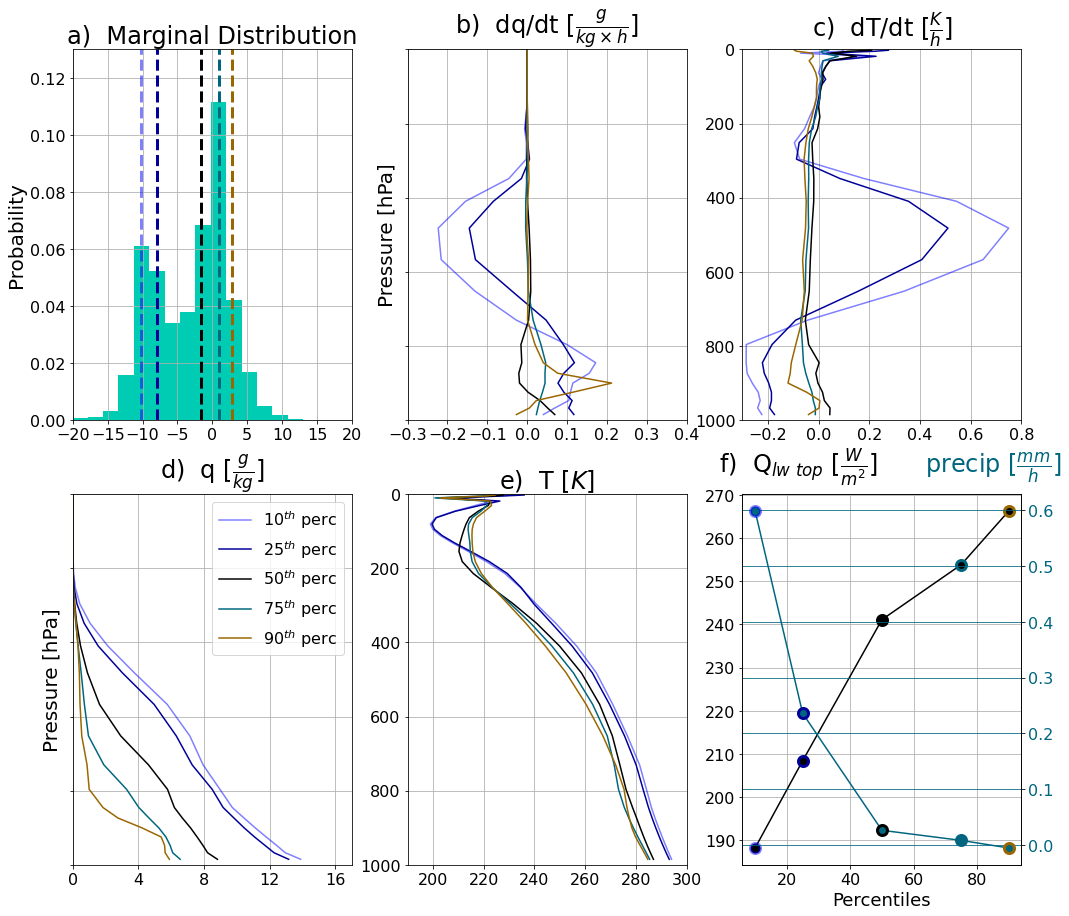

In [38]:
quad_plot_profiles_updat_rev(encoder_resp_[:,3],np.median(encoder_resp_[:,3]),
                   encoder_resp_perc_10[:,3],encoder_resp_perc_25[:,3],encoder_resp_perc_75[:,3],
                   encoder_resp_perc_90[:,3],0.13,Overall_median.T,Fifth_perc_10_median.T,Fifth_perc_25_median.T,
                         Fifth_perc_75_median.T,Fifth_perc_90_median.T,
                   P,62,64,all_labels,scaling_arr,'10$^{th}$ perc','25$^{th}$ perc','50$^{th}$ perc',
                   '75$^{th}$ perc','90$^{th}$ perc',eval_perc)

# Correlation analysis 

In [41]:
encoder_resp_.shape

(36167680, 5)

In [42]:
np.corrcoef(encoder_resp_[:,0],encoder_resp_[:,1])

array([[ 1.       , -0.7437185],
       [-0.7437185,  1.       ]])

In [43]:
np.corrcoef(encoder_resp_[:,0],encoder_resp_[:,2])

array([[1.       , 0.3551352],
       [0.3551352, 1.       ]])

In [44]:
np.corrcoef(encoder_resp_[:,0],encoder_resp_[:,3])

array([[ 1.        , -0.50196148],
       [-0.50196148,  1.        ]])

In [45]:
np.corrcoef(encoder_resp_[:,0],encoder_resp_[:,4])

array([[1.        , 0.03216301],
       [0.03216301, 1.        ]])

In [46]:
def correlate_map(encoder_response):
    correl_map=np.nan*np.zeros((5,5))
    
    for i in tqdm(np.arange(correl_map[0,:].size)):
        for j in np.arange(correl_map[0,:].size):
            
            correl_map[i,j]=np.corrcoef(encoder_resp_[:,i],encoder_resp_[:,j])[0,1]
            
    return correl_map
            
            
            

        
    

In [47]:
cor_map_nodes=correlate_map(encoder_resp_)

<ipython-input-46-dd7171e23c58>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(correl_map[0,:].size)):


Text(0.5, 1.0, 'Covariance matrix of Latent Nodes')

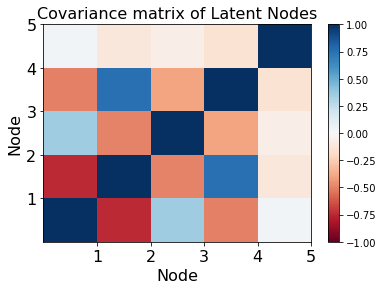

In [48]:
plt.figure(1,(6,4))
plt.pcolormesh(cor_map_nodes,cmap=plt.cm.RdBu,vmin=-1,vmax=1)
plt.colorbar()
plt.xlabel('Node', fontsize=16)
plt.ylabel('Node', fontsize=16)
plt.xticks(np.arange(1,6),fontsize=16)
plt.yticks(np.arange(1,6),fontsize=16)
plt.title('Covariance matrix of Latent Nodes',fontsize=16)

In [49]:
def correlate_map_3D(encoder_response):
    correl_map=np.nan*np.zeros((8192,5,5))
    
    encoder_resp_map=np.reshape(encoder_response,(4415,8192,5))
    
    for i in tqdm(np.arange(correl_map[0,:,0].size)):
        for j in np.arange(correl_map[0,0,:].size):
            for h in np.arange(encoder_resp_map[1,:,1].size):
            
                correl_map[h,i,j]=np.corrcoef(encoder_resp_map[:,h,i],encoder_resp_map[:,h,j])[0,1]
            
    return correl_map
            
            

In [50]:
cor_map_nodes_lat_lon=correlate_map_3D(encoder_resp_)

<ipython-input-49-ee81922a061f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(correl_map[0,:,0].size)):


Text(0.5, 1.0, 'Mean Cov. matrix of Latent Nodes Lat-Lon Space')

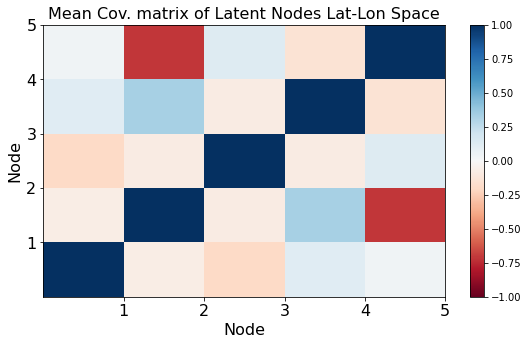

In [51]:
plt.figure(1,(9,5))
plt.pcolormesh(np.mean(cor_map_nodes_lat_lon,0),cmap=plt.cm.RdBu,vmin=-1,vmax=1)
plt.colorbar()
plt.xlabel('Node', fontsize=16)
plt.ylabel('Node', fontsize=16)
plt.xticks(np.arange(1,6),fontsize=16)
plt.yticks(np.arange(1,6),fontsize=16)
plt.title('Mean Cov. matrix of Latent Nodes Lat-Lon Space',fontsize=16)

Text(0.5, 1.0, 'Median Cov. matrix of Latent Nodes Lat-Lon Space')

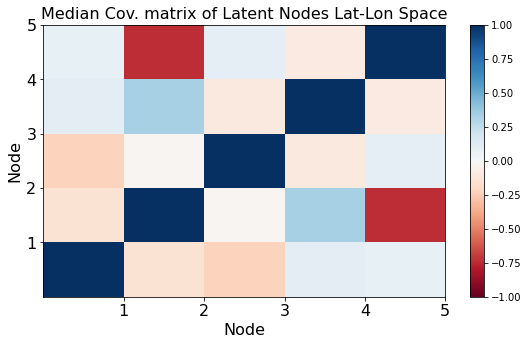

In [52]:
plt.figure(1,(9,5))
plt.pcolormesh(np.median(cor_map_nodes_lat_lon,0),cmap=plt.cm.RdBu,vmin=-1,vmax=1)
plt.colorbar()
plt.xlabel('Node', fontsize=16)
plt.ylabel('Node', fontsize=16)
plt.xticks(np.arange(1,6),fontsize=16)
plt.yticks(np.arange(1,6),fontsize=16)
plt.title('Median Cov. matrix of Latent Nodes Lat-Lon Space',fontsize=16)

Text(0.5, 1.0, 'Median Cov. matrix of Latent Nodes Lat-Lon Space')

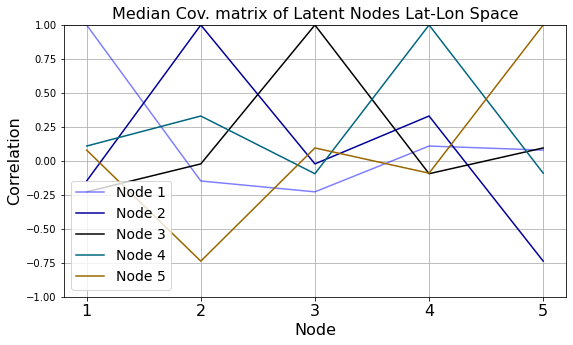

In [55]:
c_map=[[0,0,1,0.5],[0,0,0.6,1],[0,0,0,1],[0,0.4,0.5,1],[0.6,0.4,0,1]]

plt.figure(1,(9,5))

plt.plot(np.arange(1,6),np.median(cor_map_nodes_lat_lon,0)[:,0],color=c_map[0],label='Node 1')
plt.plot(np.arange(1,6),np.median(cor_map_nodes_lat_lon,0)[:,1],color=c_map[1],label='Node 2')
plt.plot(np.arange(1,6),np.median(cor_map_nodes_lat_lon,0)[:,2],color=c_map[2],label='Node 3')
plt.plot(np.arange(1,6),np.median(cor_map_nodes_lat_lon,0)[:,3],color=c_map[3],label='Node 4')
plt.plot(np.arange(1,6),np.median(cor_map_nodes_lat_lon,0)[:,4],color=c_map[4],label='Node 5')
plt.legend(fontsize=14,loc=3)
plt.ylim(-1,1)
plt.grid(True)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.xticks(np.arange(1,6),fontsize=16)
#plt.yticks(np.arange(1,6),fontsize=16)
plt.title('Median Cov. matrix of Latent Nodes Lat-Lon Space',fontsize=16)

Text(0.5, 1.0, 'Mean Cov. matrix of Latent Nodes Lat-Lon Space')

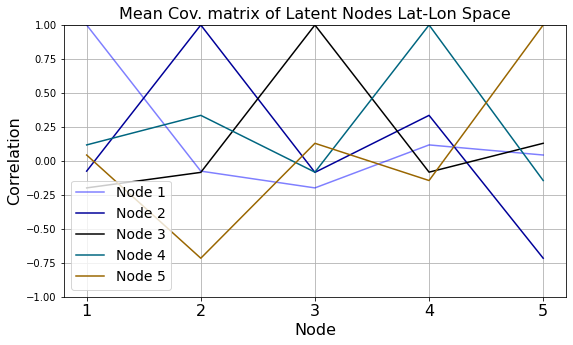

In [56]:
plt.figure(1,(9,5))

plt.plot(np.arange(1,6),np.mean(cor_map_nodes_lat_lon,0)[:,0],color=c_map[0],label='Node 1')
plt.plot(np.arange(1,6),np.mean(cor_map_nodes_lat_lon,0)[:,1],color=c_map[1],label='Node 2')
plt.plot(np.arange(1,6),np.mean(cor_map_nodes_lat_lon,0)[:,2],color=c_map[2],label='Node 3')
plt.plot(np.arange(1,6),np.mean(cor_map_nodes_lat_lon,0)[:,3],color=c_map[3],label='Node 4')
plt.plot(np.arange(1,6),np.mean(cor_map_nodes_lat_lon,0)[:,4],color=c_map[4],label='Node 5')
plt.legend(fontsize=14,loc=3)
plt.ylim(-1,1)
plt.grid(True)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.xticks(np.arange(1,6),fontsize=16)
#plt.yticks(np.arange(1,6),fontsize=16)
plt.title('Mean Cov. matrix of Latent Nodes Lat-Lon Space',fontsize=16)